***3. Preprocessing_Facilities and Services***

In [2]:
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_nyc = pd.read_csv('nyc_with_distances.csv')

C:\Users\sylvi\AppData\Local\Temp\ipykernel_13736\3094127854.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nyc = pd.read_csv('nyc_with_distances.csv')


Amenities

In [5]:
print(f"Number of missing values in 'amenities': {df_nyc['amenities'].isnull().sum()}")

Number of missing values in 'amenities': 0


1) choose Top50 Amenities（after deleting 'translation missing' items)

In [7]:
df_nyc['amenities_list'] = df_nyc['amenities'].apply(lambda x: [item.strip('"') for item in x.strip('{}').split(',')]) 
df_nyc['amenities_list'] = df_nyc['amenities_list'].apply(lambda x: [item.strip().capitalize() for item in x])

In [8]:
exploded_df = df_nyc.explode('amenities_list')

amenities_counts = exploded_df['amenities_list'].value_counts()

In [9]:
print(amenities_counts.head(50))

amenities_list
Wireless internet                             17510
Heating                                       16838
Kitchen                                       16505
Essentials                                    15891
Air conditioning                              15757
Smoke detector                                14935
Hangers                                       12910
Carbon monoxide detector                      11994
Tv                                            11830
Shampoo                                       11690
Hair dryer                                    11561
Iron                                          11029
Laptop friendly workspace                     10926
Internet                                       9863
Family/kid friendly                            8336
Translation missing: en.hosting_amenity_50     7084
First aid kit                                  6636
Fire extinguisher                              6558
Washer                                         65

In [10]:
df_nyc['amenities_list'] = df_nyc['amenities_list'].apply(lambda x: [item.strip() for item in x if not item.strip().lower().startswith('translation missing')])
df_nyc['amenities_list'] = df_nyc['amenities_list'].apply(lambda x: [item.strip().capitalize() for item in x])

translation_missing_items = [item for sublist in df_nyc['amenities_list'] for item in sublist if 'translation missing' in item.lower()]
print(f"Remaining 'translation_missing' items: {set(translation_missing_items)}")

Remaining 'translation_missing' items: set()


In [11]:
exploded_df = df_nyc.explode('amenities_list')
amenities_counts = exploded_df['amenities_list'].value_counts()
print(amenities_counts.head(50))

amenities_list
Wireless internet             17510
Heating                       16838
Kitchen                       16505
Essentials                    15891
Air conditioning              15757
Smoke detector                14935
Hangers                       12910
Carbon monoxide detector      11994
Tv                            11830
Shampoo                       11690
Hair dryer                    11561
Iron                          11029
Laptop friendly workspace     10926
Internet                       9863
Family/kid friendly            8336
First aid kit                  6636
Fire extinguisher              6558
Washer                         6548
Dryer                          6534
Buzzer/wireless intercom       6524
Cable tv                       5198
Lock on bedroom door           4907
Elevator                       4455
24-hour check-in               3949
Self check-in                  3026
Safety card                    2596
Refrigerator                   2480
Dishes and si

2) change data into Boolean type and save the data into a new file

In [13]:
top_50_amenities = amenities_counts.head(50).index

for amenity in top_50_amenities:
    column_name = amenity.strip().replace(' ', '_')  
    df_nyc[column_name] = df_nyc['amenities_list'].apply(lambda x: amenity in x)

df_nyc.drop(columns=['amenities_list'], inplace=True)

df_nyc.to_csv('nyc_with_top_50_amenities.csv', index=False)

print("Dataset with top 50 amenities saved as 'nyc_with_top_50_amenities.csv'")

Dataset with top 50 amenities saved as 'nyc_with_top_50_amenities.csv'


3) Visualize （use TOP5 as example)

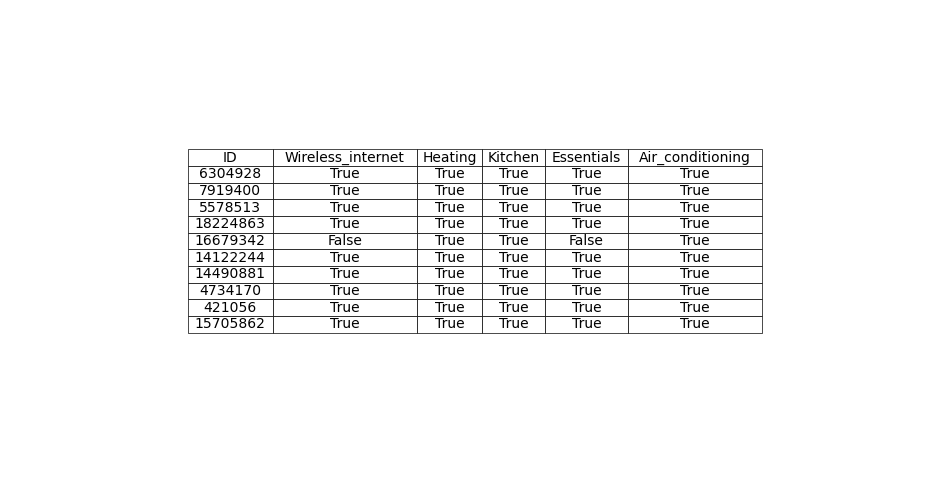

In [15]:
top_5_amenities = amenities_counts.head(5).index
top_5_columns = [amenity.strip().replace(' ', '_') for amenity in top_5_amenities]

top_5_with_ids = df_nyc[['id'] + top_5_columns].head(10).set_index('id')
top_5_str_df = top_5_with_ids.replace({True: 'True', False: 'False'})

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=top_5_str_df.reset_index().values,  
    colLabels=['ID'] + list(top_5_str_df.columns),  
    cellLoc='center',
    loc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(top_5_str_df.columns) + 1)))

for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(0.5)

plt.show()

4) correlation (Top50/20)

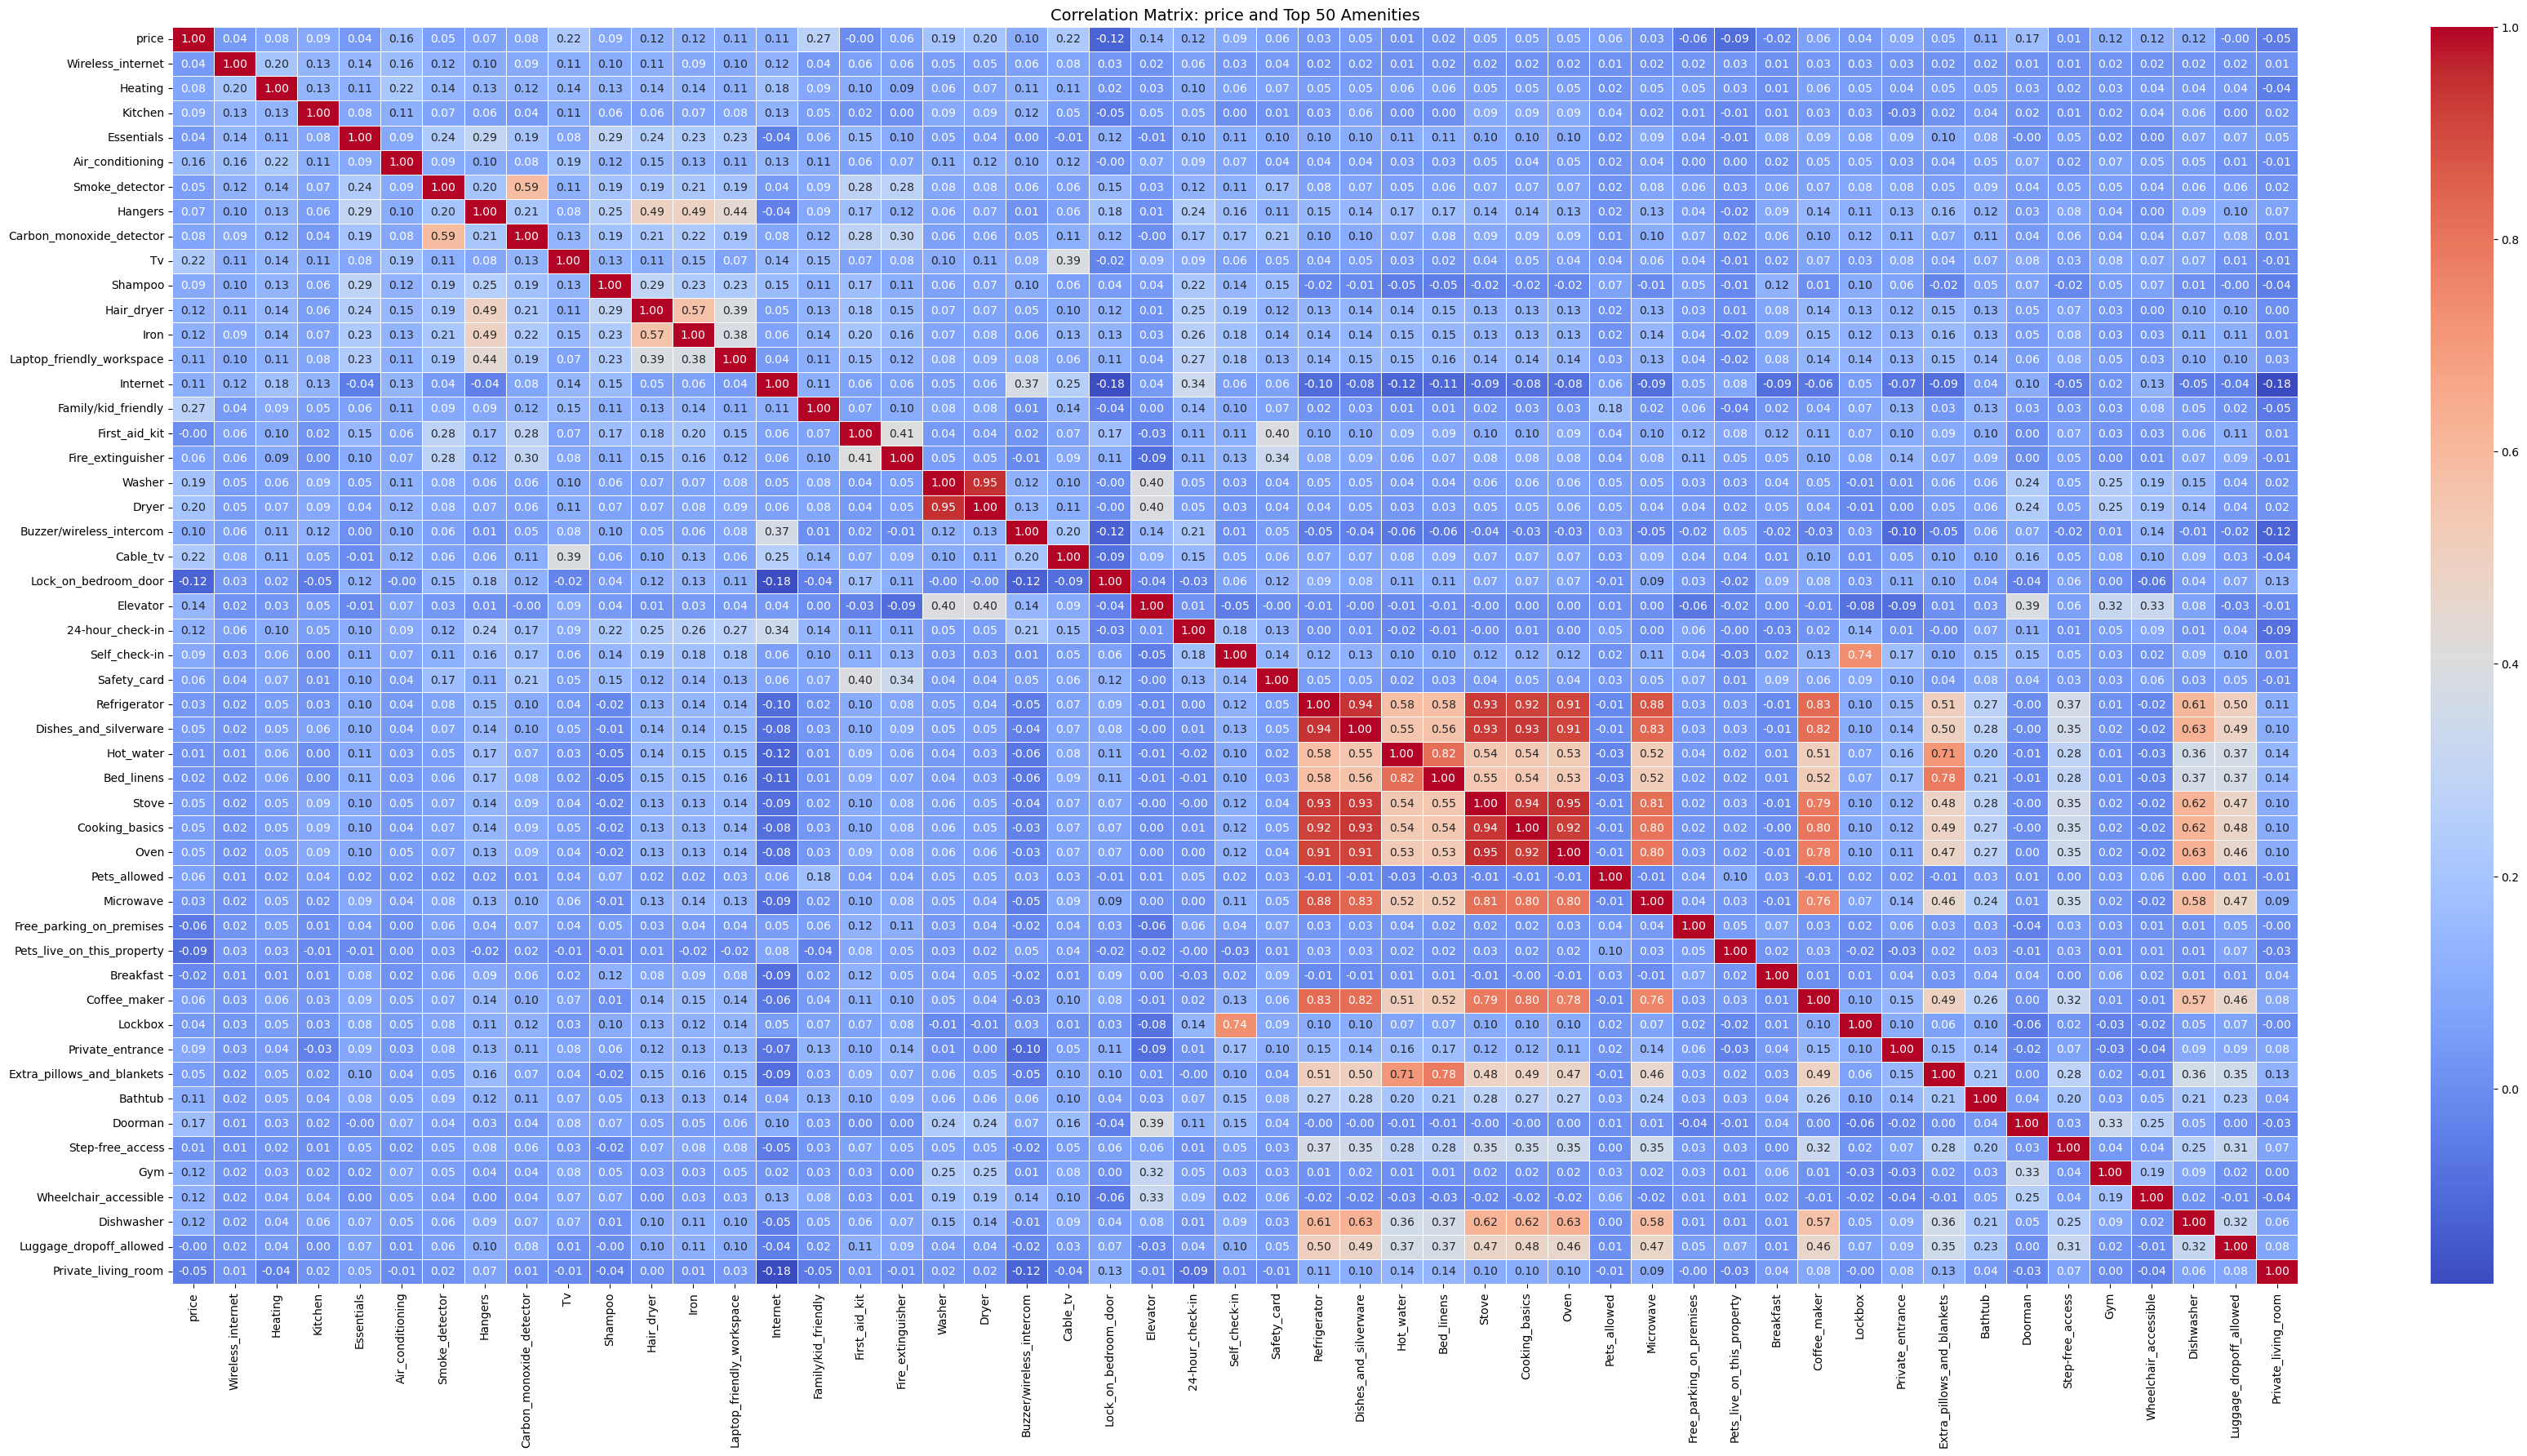

In [17]:
top_50_df = df_nyc[['price'] + [amenity.strip().replace(' ', '_') for amenity in top_50_amenities]]

correlation_matrix = top_50_df.corr()

plt.figure(figsize=(42, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Matrix: price and Top 50 Amenities", fontsize=14)
plt.show()


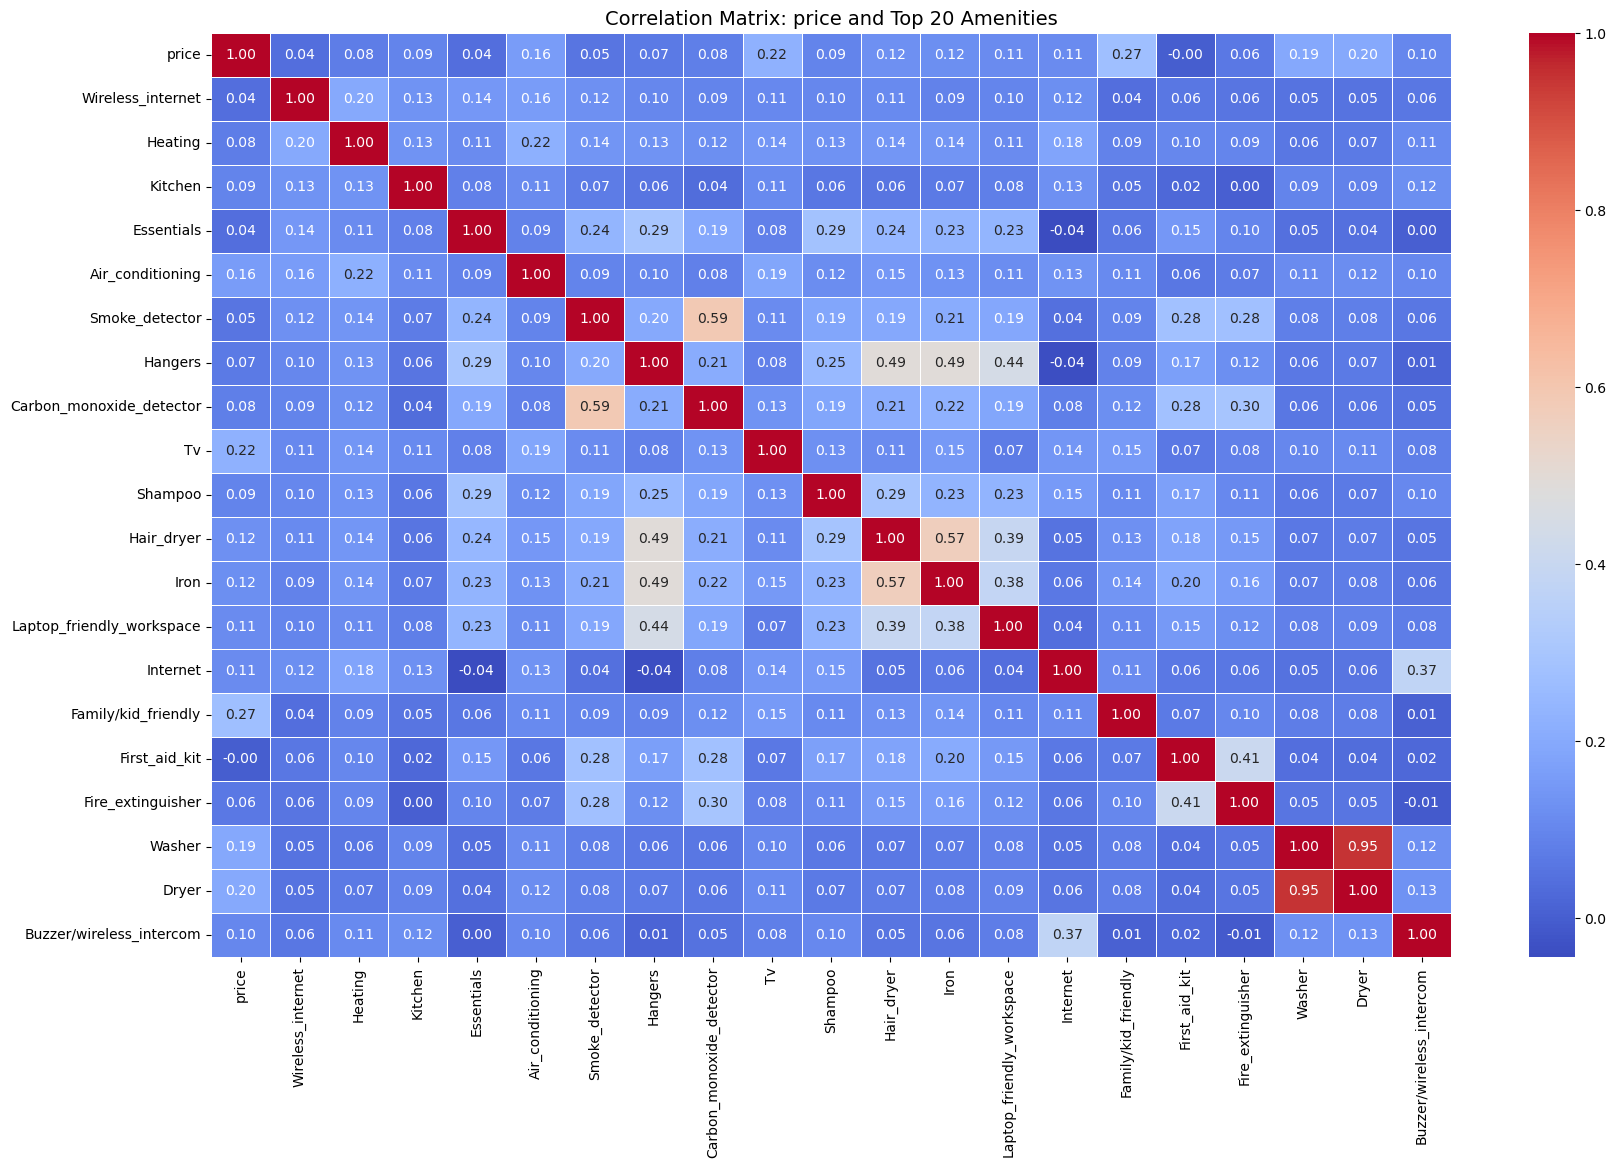

In [18]:
top_20_amenities = amenities_counts.head(20).index

top_20_df = df_nyc[['price'] + [amenity.strip().replace(' ', '_') for amenity in top_20_amenities]]

correlation_matrix = top_20_df.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation Matrix: price and Top 20 Amenities", fontsize=14)
plt.show()

5) Analyze 'First Aid Kit'(negative correlation)

In [20]:
grouped_data = df_nyc.groupby(['property_type', 'First_aid_kit'])['price'].agg(['count', 'mean']).reset_index()

total_count_per_type = grouped_data.groupby('property_type')['count'].transform('sum')
grouped_data['percentage'] = grouped_data['count'] / total_count_per_type * 100

print(grouped_data)

         property_type  First_aid_kit  count        mean  percentage
0            Apartment          False   9606  140.692588   65.979806
1            Apartment           True   4953  136.769635   34.020194
2      Bed & Breakfast          False     26  114.269231   41.269841
3      Bed & Breakfast           True     37  153.702703   58.730159
4                 Boat          False      3  142.000000  100.000000
5       Boutique hotel          False      4  113.500000   57.142857
6       Boutique hotel           True      3  139.000000   42.857143
7             Bungalow          False      8  161.250000   88.888889
8             Bungalow           True      1   95.000000   11.111111
9                Cabin          False      1   80.000000   50.000000
10               Cabin           True      1  250.000000   50.000000
11              Castle           True      1  175.000000  100.000000
12              Chalet          False      1   99.000000   33.333333
13              Chalet           T

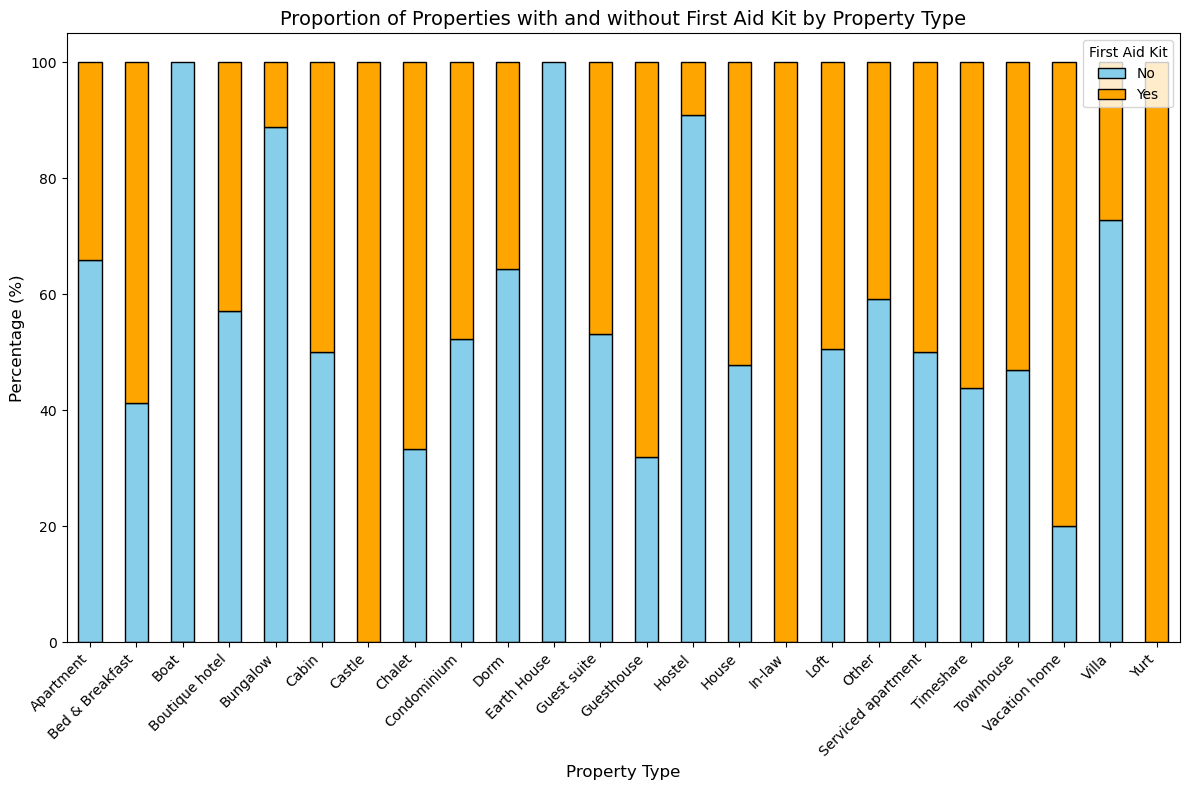

In [21]:
pivot_percentage = grouped_data.pivot(index='property_type', columns='First_aid_kit', values='percentage').fillna(0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(12, 8), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Proportion of Properties with and without First Aid Kit by Property Type', fontsize=14)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='First Aid Kit', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

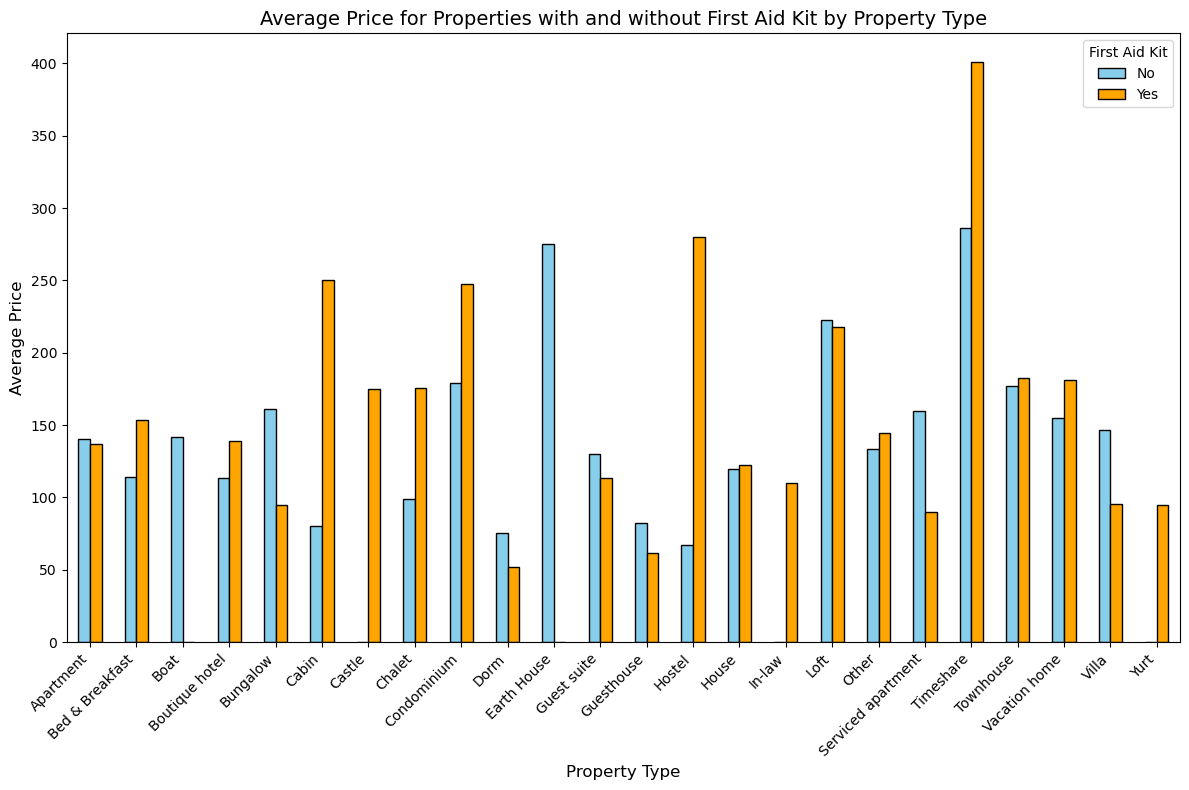

In [22]:
pivot_mean = grouped_data.pivot(index='property_type', columns='First_aid_kit', values='mean').fillna(0)

pivot_mean.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Average Price for Properties with and without First Aid Kit by Property Type', fontsize=14)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='First Aid Kit', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

Cancellation policy

cancellation_policy
strict             9734
moderate           4783
flexible           3332
super_strict_30       3
super_strict_60       1
Name: count, dtype: int64


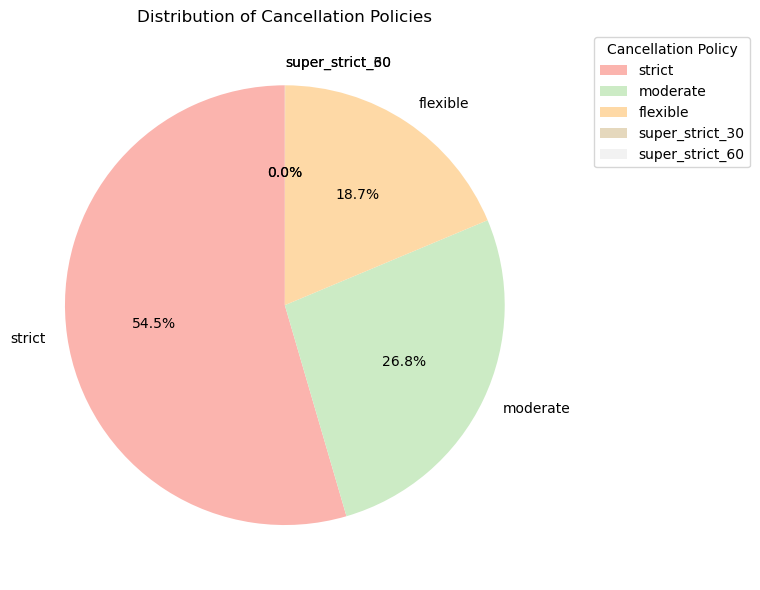

In [24]:
cancellation_counts = df_nyc['cancellation_policy'].value_counts()
print(cancellation_counts)

plt.figure(figsize=(8, 6))
cancellation_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title('Distribution of Cancellation Policies')
plt.ylabel('')  
plt.legend(title='Cancellation Policy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [25]:
df_nyc = df_nyc[~df_nyc['cancellation_policy'].isin(['super_strict_30', 'super_strict_60'])]

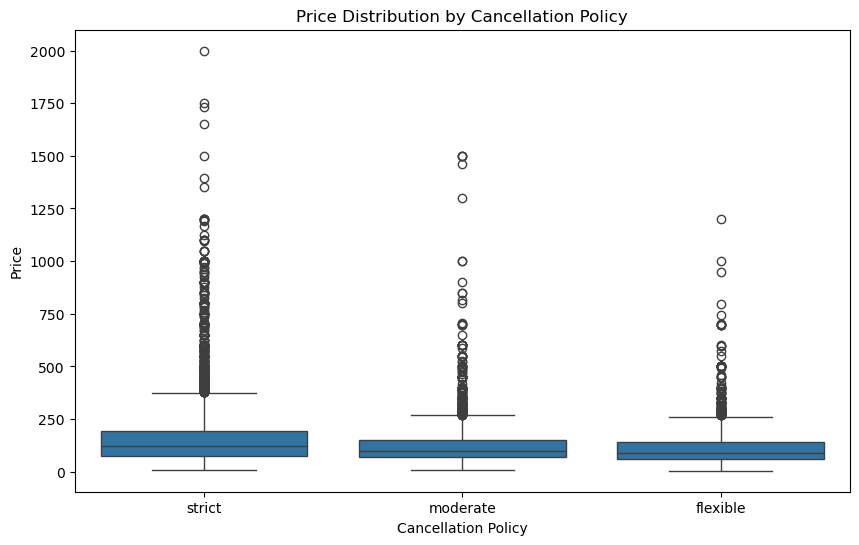

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_nyc, x='cancellation_policy', y='price')
plt.title('Price Distribution by Cancellation Policy')
plt.xlabel('Cancellation Policy')
plt.ylabel('Price')
plt.show()

Cleaning_fee

In [28]:
cleaning_fee_distribution = df_nyc['cleaning_fee'].value_counts(normalize=True) * 100

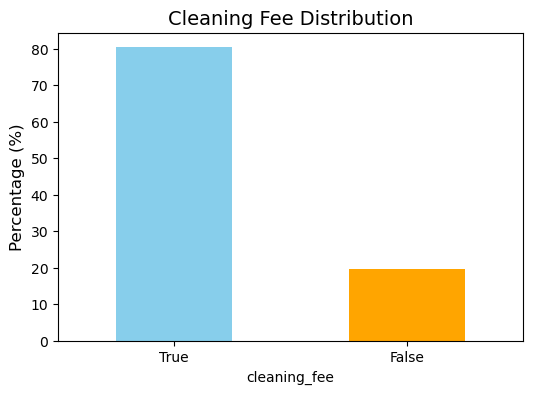

In [29]:
cleaning_fee_distribution.plot(kind='bar', color=['skyblue', 'orange'], figsize=(6, 4))
plt.title("Cleaning Fee Distribution", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.show()

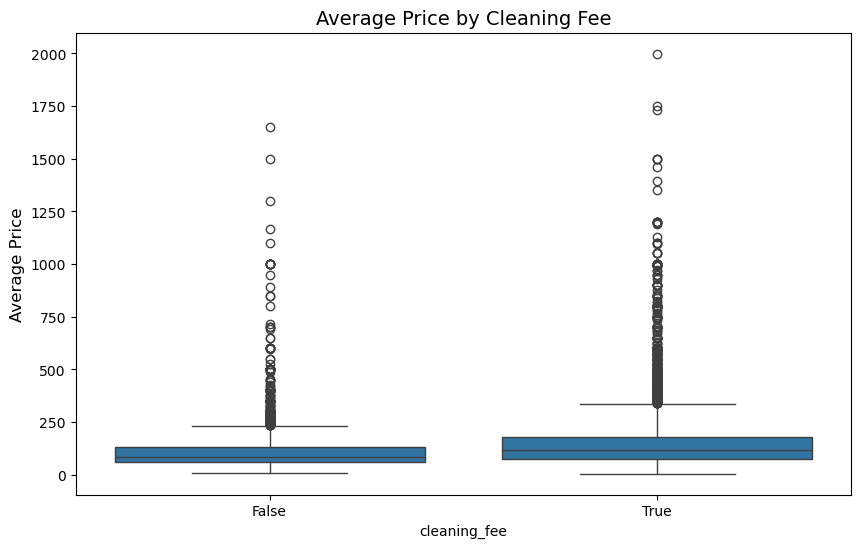

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_nyc, x='cleaning_fee', y='price')
plt.title("Average Price by Cleaning Fee", fontsize=14)
plt.ylabel("Average Price", fontsize=12)
plt.xticks(rotation=0)
plt.show()

Instant_bookable

In [32]:
df_nyc['instant_bookable'] = df_nyc['instant_bookable'].map({'t': True, 'f': False})

In [33]:
instant_bookable_distribution = df_nyc['instant_bookable'].value_counts(normalize=True) * 100

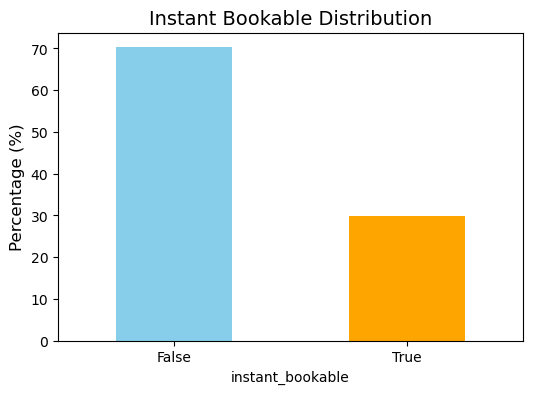

In [34]:
instant_bookable_distribution.plot(kind='bar', color=['skyblue', 'orange'], figsize=(6, 4))
plt.title("Instant Bookable Distribution", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.show()

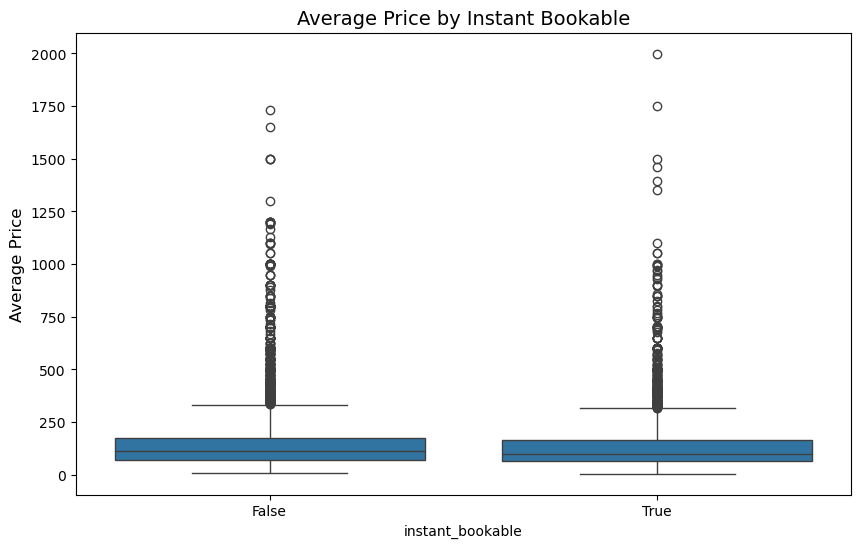

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_nyc, x='instant_bookable', y='price')
plt.title("Average Price by Instant Bookable", fontsize=14)
plt.ylabel("Average Price", fontsize=12)
plt.xticks(rotation=0)
plt.show()


In [36]:
df_nyc['instant_bookable_numeric'] = df_nyc['instant_bookable'].map({True: 1, False: 0})

correlation = df_nyc['instant_bookable_numeric'].corr(df_nyc['price'])

print(f"Correlation between instant_bookable and price: {correlation:.2f}")

Correlation between instant_bookable and price: -0.03
